In [3]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
num_days = 540  # ~18 months
num_skus = 40
num_warehouses = 4
start_date = pd.to_datetime("2024-01-01")
dates = pd.date_range(start_date, periods=num_days)

records = []

# Generate SKU-level patterns
for sku in range(1, num_skus + 1):
    base_demand = np.random.randint(10, 80)  # avg daily demand
    seasonality_amplitude = np.random.randint(10, 30)
    trend = np.linspace(0, np.random.randint(-10, 20), num_days)  # some SKUs growing/declining
    promo_weeks = np.random.choice(range(num_days), size=10, replace=False)  # random promo days

    for wh in range(1, num_warehouses + 1):
        for i, d in enumerate(dates):
            # Seasonal + trend + random noise
            seasonal = seasonality_amplitude * np.sin(2 * np.pi * (i % 365) / 365)
            noise = np.random.normal(0, 5)
            promo_boost = 1.5 if i in promo_weeks else 1.0
            demand = base_demand + seasonal + trend[i] + noise
            demand = max(0, int(demand * promo_boost))

            price = np.random.choice([499, 699, 999, 1299, 1499])
            discount = np.random.choice([0, 10, 20, 30, 40])
            records.append([d, f"SKU{sku:03}", wh, demand, price, discount])

# Create DataFrame
df = pd.DataFrame(records, columns=['order_date', 'sku', 'warehouse_id', 'qty', 'price', 'discount'])

# Save dataset
df.to_csv("sales_data_medium.csv", index=False)

print("✅ Medium synthetic dataset created and saved as 'sales_data_medium.csv'")
print(f"Total records: {len(df):,}")
print(df.head(10))


✅ Medium synthetic dataset created and saved as 'sales_data_medium.csv'
Total records: 86,400
  order_date     sku  warehouse_id  qty  price  discount
0 2024-01-01  SKU001             1   57   1499        10
1 2024-01-02  SKU001             1   59   1499        20
2 2024-01-03  SKU001             1   63   1499        40
3 2024-01-04  SKU001             1   65    499        30
4 2024-01-05  SKU001             1   65    999         0
5 2024-01-06  SKU001             1   59    999        30
6 2024-01-07  SKU001             1   69   1499        30
7 2024-01-08  SKU001             1   60    499        40
8 2024-01-09  SKU001             1   59    499         0
9 2024-01-10  SKU001             1   68   1299         0


In [7]:
!pip install lightgbm


In [4]:
df = pd.read_csv("sales_data_medium.csv")
df['order_date'] = pd.to_datetime(df['order_date'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86400 entries, 0 to 86399
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   order_date    86400 non-null  datetime64[ns]
 1   sku           86400 non-null  object        
 2   warehouse_id  86400 non-null  int64         
 3   qty           86400 non-null  int64         
 4   price         86400 non-null  int64         
 5   discount      86400 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 4.0+ MB


In [5]:
daily = df.groupby(['order_date','sku','warehouse_id']).qty.sum().reset_index()
daily = daily.rename(columns={'order_date':'date','qty':'sales'})


In [8]:
# -------------------------------------------------------------
# 📦 STEP 1 — Load and prepare dataset
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load medium dataset
df = pd.read_csv("sales_data_medium.csv")
df['order_date'] = pd.to_datetime(df['order_date'])

# Aggregate daily sales per SKU × warehouse
daily = df.groupby(['order_date', 'sku', 'warehouse_id']).qty.sum().reset_index()
daily = daily.rename(columns={'order_date': 'date', 'qty': 'sales'})
daily = daily.sort_values(['sku', 'warehouse_id', 'date']).reset_index(drop=True)

print("✅ Data ready:", daily.shape)
daily.head()


✅ Data ready: (86400, 4)


,date,sku,warehouse_id,sales
0,2024-01-01,SKU001,1,57
1,2024-01-02,SKU001,1,59
2,2024-01-03,SKU001,1,63
3,2024-01-04,SKU001,1,65
4,2024-01-05,SKU001,1,65


In [9]:
# -------------------------------------------------------------
# 📊 STEP 2 — Feature Engineering
# -------------------------------------------------------------
lags = [1, 7, 14, 28]  # past days to use
rolling_windows = [7, 14, 30]

# Sort for time order
daily = daily.sort_values(['sku', 'warehouse_id', 'date'])

# Create lag features
for lag in lags:
    daily[f'lag_{lag}'] = daily.groupby(['sku', 'warehouse_id'])['sales'].shift(lag)

# Rolling mean/std features
for window in rolling_windows:
    daily[f'roll_mean_{window}'] = daily.groupby(['sku', 'warehouse_id'])['sales'].transform(lambda x: x.shift(1).rolling(window).mean())
    daily[f'roll_std_{window}'] = daily.groupby(['sku', 'warehouse_id'])['sales'].transform(lambda x: x.shift(1).rolling(window).std())

# Calendar / time features
daily['dayofweek'] = daily['date'].dt.dayofweek
daily['month'] = daily['date'].dt.month
daily['is_weekend'] = (daily['dayofweek'] >= 5).astype(int)

# Fill NA (for early lags)
daily.fillna(0, inplace=True)

print("✅ Feature engineering done. Feature columns:", daily.columns.tolist())
daily.head()


✅ Feature engineering done. Feature columns: ['date', 'sku', 'warehouse_id', 'sales', 'lag_1', 'lag_7', 'lag_14', 'lag_28', 'roll_mean_7', 'roll_std_7', 'roll_mean_14', 'roll_std_14', 'roll_mean_30', 'roll_std_30', 'dayofweek', 'month', 'is_weekend']


,date,sku,warehouse_id,sales,lag_1,lag_7,lag_14,lag_28,roll_mean_7,roll_std_7,roll_mean_14,roll_std_14,roll_mean_30,roll_std_30,dayofweek,month,is_weekend
0,2024-01-01,SKU001,1,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1,2024-01-02,SKU001,1,59,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
2,2024-01-03,SKU001,1,63,59.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,0
3,2024-01-04,SKU001,1,65,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,0
4,2024-01-05,SKU001,1,65,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,0


In [10]:
# -------------------------------------------------------------
# ⚙️ STEP 3 — Prepare train/test split
# -------------------------------------------------------------
# Use last 60 days as test period
train_df = daily[daily['date'] < daily['date'].max() - pd.Timedelta(days=60)]
test_df  = daily[daily['date'] >= daily['date'].max() - pd.Timedelta(days=60)]

features = [c for c in daily.columns if c not in ['date','sales','sku','warehouse_id']]

X_train, y_train = train_df[features], train_df['sales']
X_test,  y_test  = test_df[features],  test_df['sales']

print("Training samples:", len(X_train), " | Test samples:", len(X_test))


Training samples: 76640  | Test samples: 9760


In [12]:
model = lgb.train(
    params=params,
    train_set=train_data,
    num_boost_round=500,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'test'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(50)
    ]
)


Training until validation scores don't improve for 50 rounds
[50]	train's l1: 4.85616	test's l1: 4.89662
[100]	train's l1: 4.48364	test's l1: 4.7049
[150]	train's l1: 4.44212	test's l1: 4.701
Early stopping, best iteration is:
[138]	train's l1: 4.44949	test's l1: 4.69876


In [13]:
import matplotlib.pyplot as plt

# We'll pick one SKU for demonstration
sku = 'SKU010'
warehouse = 1

# Filter for that SKU and warehouse
sku_data = daily[(daily['sku'] == sku) & (daily['warehouse_id'] == warehouse)].copy()

# Compute daily demand stats
avg_demand = sku_data['sales'].mean()
std_demand = sku_data['sales'].std()

# Inventory parameters
lead_time = 7   # days to restock
service_level = 0.95  # desired probability of no stockout
z = 1.65  # z-score for 95% service level
holding_cost_per_unit = 2
stockout_cost_per_unit = 10
order_cost = 200

# Safety Stock Formula
safety_stock = z * std_demand * np.sqrt(lead_time)

# Reorder Point
reorder_point = avg_demand * lead_time + safety_stock

# EOQ (Economic Order Quantity)
annual_demand = avg_demand * 365
eoq = np.sqrt((2 * order_cost * annual_demand) / holding_cost_per_unit)

print(f"📦 SKU: {sku}, Warehouse: {warehouse}")
print(f"Average Daily Demand: {avg_demand:.2f}")
print(f"Standard Deviation of Demand: {std_demand:.2f}")
print(f"Safety Stock: {safety_stock:.2f}")
print(f"Reorder Point: {reorder_point:.2f}")
print(f"Economic Order Quantity (EOQ): {eoq:.2f}")


📦 SKU: SKU010, Warehouse: 1
Average Daily Demand: 69.26
Standard Deviation of Demand: 18.49
Safety Stock: 80.70
Reorder Point: 565.52
Economic Order Quantity (EOQ): 2248.54


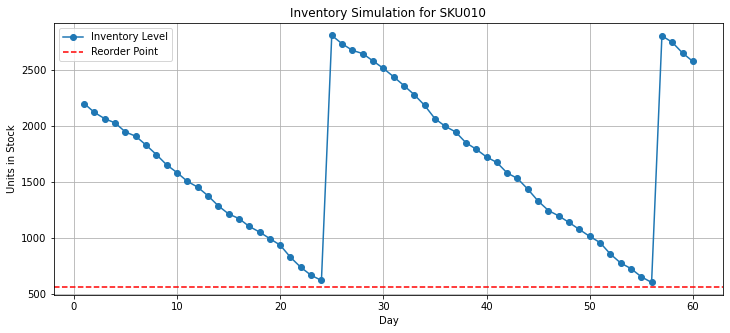

In [14]:
# Simulate inventory for 60 days
days = np.arange(1, 61)
inventory = []
on_hand = eoq
for d in days:
    demand = max(0, np.random.normal(avg_demand, std_demand))
    on_hand -= demand
    if on_hand <= reorder_point:
        on_hand += eoq  # Reorder placed
    inventory.append(on_hand)

plt.figure(figsize=(12,5))
plt.plot(days, inventory, label='Inventory Level', marker='o')
plt.axhline(reorder_point, color='r', linestyle='--', label='Reorder Point')
plt.title(f'Inventory Simulation for {sku}')
plt.xlabel('Day')
plt.ylabel('Units in Stock')
plt.legend()
plt.grid()
plt.show()


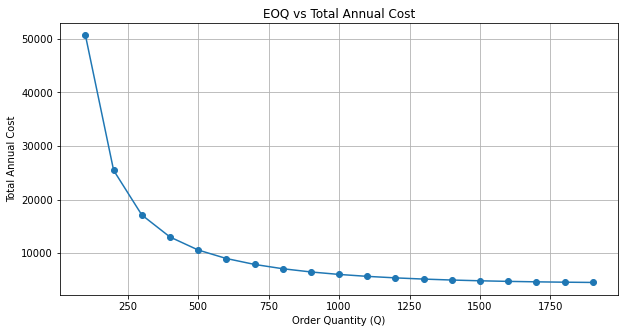

In [15]:
eoq_values = np.arange(100, 2000, 100)
total_costs = []

for q in eoq_values:
    annual_orders = annual_demand / q
    ordering_cost = annual_orders * order_cost
    holding_cost = (q / 2) * holding_cost_per_unit
    total_costs.append(ordering_cost + holding_cost)

plt.figure(figsize=(10,5))
plt.plot(eoq_values, total_costs, marker='o')
plt.title('EOQ vs Total Annual Cost')
plt.xlabel('Order Quantity (Q)')
plt.ylabel('Total Annual Cost')
plt.grid()
plt.show()


In [16]:
summary = {
    'SKU': sku,
    'Warehouse': warehouse,
    'Avg Daily Demand': round(avg_demand,2),
    'Std Demand': round(std_demand,2),
    'Safety Stock': round(safety_stock,2),
    'Reorder Point': round(reorder_point,2),
    'EOQ': round(eoq,2)
}
summary_df = pd.DataFrame([summary])
summary_df


,SKU,Warehouse,Avg Daily Demand,Std Demand,Safety Stock,Reorder Point,EOQ
0,SKU010,1,69.26,18.49,80.7,565.52,2248.54


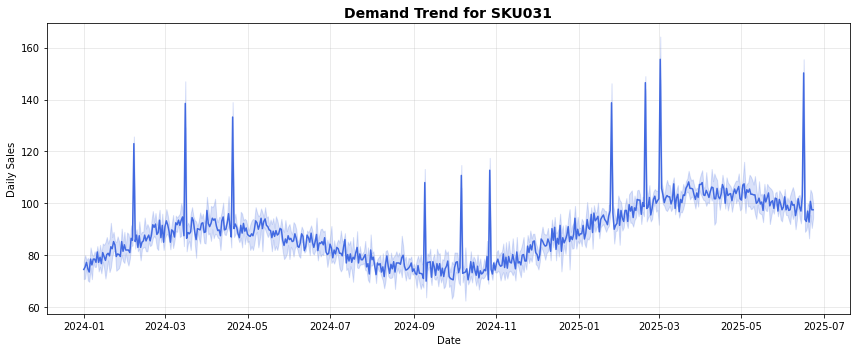

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identify top-selling SKU
top_sku = daily.groupby('sku')['sales'].sum().sort_values(ascending=False).index[0]

# Filter data
top_data = daily[daily['sku'] == top_sku]

# Plot
plt.figure(figsize=(12,5))
sns.lineplot(data=top_data, x='date', y='sales', color='royalblue')
plt.title(f'Demand Trend for {top_sku}', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


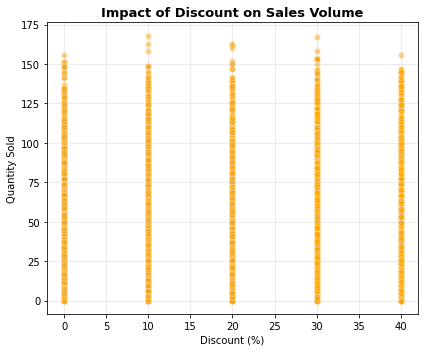

In [18]:
plt.figure(figsize=(6,5))
sns.scatterplot(data=df, x='discount', y='qty', alpha=0.5, color='orange')
plt.title('Impact of Discount on Sales Volume', fontsize=13, fontweight='bold')
plt.xlabel('Discount (%)')
plt.ylabel('Quantity Sold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


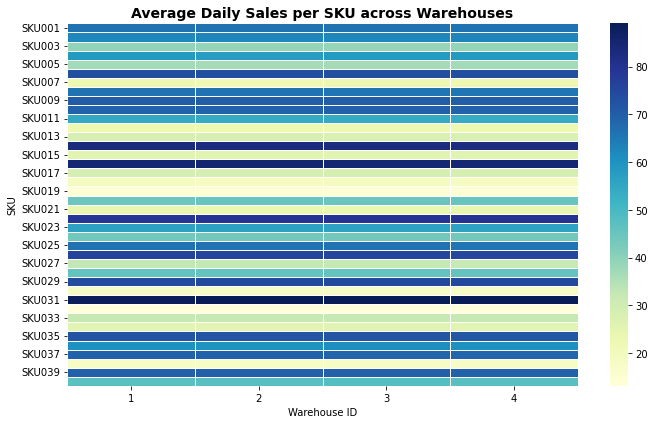

In [19]:
pivot_table = daily.pivot_table(values='sales', index='sku', columns='warehouse_id', aggfunc='mean')

plt.figure(figsize=(10,6))
sns.heatmap(pivot_table, cmap='YlGnBu', linewidths=0.5)
plt.title('Average Daily Sales per SKU across Warehouses', fontsize=14, fontweight='bold')
plt.xlabel('Warehouse ID')
plt.ylabel('SKU')
plt.tight_layout()
plt.show()


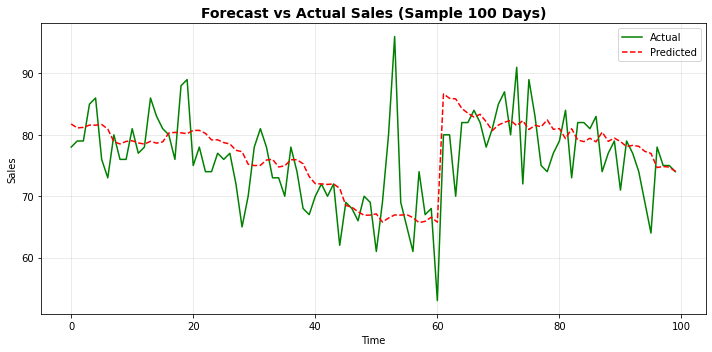

In [20]:
# (Assuming you have X_test, y_test, model already)
y_pred = model.predict(X_test)

# Create comparison DataFrame
pred_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
}).reset_index(drop=True)

plt.figure(figsize=(10,5))
plt.plot(pred_df['Actual'].values[:100], label='Actual', color='green')
plt.plot(pred_df['Predicted'].values[:100], label='Predicted', color='red', linestyle='--')
plt.title('Forecast vs Actual Sales (Sample 100 Days)', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [21]:
pip install streamlit


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.



  Using cached typing_extensions-4.15.0-py3-none-any.whl (44 kB)
  Using cached pygments-2.19.2-py3-none-any.whl (1.2 MB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.10.0
    Uninstalling Pygments-2.10.0:
      Successfully uninstalled Pygments-2.10.0
